# Data Merging & Data Transformation

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import natsort
import numpy as np
import os

from numpy.fft import fft
from mpl_toolkits.mplot3d import Axes3D

In [102]:
# 1, 2 통합 cell
def fft_spindle(data):
    # FFT
    N = len(data) # 10000 (1초간 10000개 data 측정)
    T = 1.0 / 10000 # 측정 주기
    amp_x_dis = fft(data['x_dis'].values) # fft 결과 x_dis 열의 amplitude 값
    amp_y_dis = fft(data['y_dis'].values) # fft 결과 y_dis 열의 amplitude 값
    amp_x_dis = 2.0/N * np.abs(amp_x_dis[:N//2]) # 반만 필요
    amp_y_dis = 2.0/N * np.abs(amp_y_dis[:N//2])
    freq = np.linspace(0.0, 1.0/(2.0*T), N//2) # frequency (반만 가져옴)
    return freq, amp_x_dis, amp_y_dis

def merge_and_transform(data_path_list, spindle_idx, threshold=0.001, fft_example_idx=0):
    #============================================================
    # data_path_list : TEST_160 등 데이터 들어간 폴더의 path들의 list
    # spindle_idx : 폴더 안에 SPINDLE1_TEST인지, SPINDLE2_TEST인지 등
    # threshold : 튄 값의 기준
    # fft_example_idx : fft 그려볼 index (default: 0)
    #============================================================
    transformed_dfs = []
    
    for directory in data_path_list:
        print('#########################################################')
        print("for the directory '{}'".format(directory))
        file_paths = []
        file_names = []
        for dirname, _, filenames in os.walk(directory):
            filenames = natsort.natsorted(filenames)
            for filename in filenames:
                path = os.path.join(dirname, filename)
                if (path.endswith('txt') and 'SPINDLE' + str(spindle_idx) + '_TEST' in path and '-' in path and 'RMS' not in path):
                    file_paths.append(path)
                    file_names.append(filename)
        print("Num of paths: ", len(file_paths))
    
        # 초당 데이터 FFT 변환
        t_data = []
        for i in range(len(file_paths)):
            t_data.append(pd.read_table(file_paths[i], sep='\t', header=None,
                                        names=['time', 'x_acc', 'time2', 'y_acc', 'time3', 'temperature',
                                               'time4', 'x_dis', 'time5', 'y_dis']))
            # 불필요한 열 삭제
            t_data[i].drop(['time2', 'time3', 'temperature', 'time4', 'time5'], axis=1, inplace=True)
        
        print("Num of time domain data: ", len(t_data))
        
        # 새로운 df 생성
        filteredFreq = []
        numPop_total = [] # x, y distance 총 튄 값 개수
        numPop_x = [] # x distance 튄 값 개수 list
        numPop_y = [] # y distance 튄 값 개수 list
        popVal_x = [] # x distance 튄 값들의 평균값 list
        popVal_y = [] # y distance 튄 값들의 평균값 list
        popVal_mean = [] # x, y 전체 튄 값들의 평균값 list
        
        # 20000 기준으로 나눠서 진행 (메모리 문제)
        num_data = len(t_data)
        k = num_data // 20000
        for i in range(k + 1):
            for j in range(20000 * i, 20000 * (i + 1)):
                if j >= num_data:
                    print("transformed the data!")
                    break
                elif j % 10000 == 0: print("{}th new data created!".format(j))
                else:
                    freq, pop_x, pop_y = fft_spindle(t_data[j])
                    pop_x[0] = 0 # 맨 처음 값은 FFT 특성 상 큰 값을 가지므로 무시
                    pop_y[0] = 0
                    freq = np.where(((pop_x > threshold) | (pop_y > threshold)), freq, 0)
                    # print(len(freq))
                    # print(np.count_nonzero(freq))
                    pop_x = np.where(pop_x > threshold, pop_x, 0) # 튄 값만 그대로 두고 나머지는 0
                    pop_y = np.where(pop_y > threshold, pop_y, 0)
                    # print(len(pop_x))
                    # print(np.count_nonzero(pop_x))

                    filteredFreq.append(freq[np.nonzero(freq)]) # 튄 값의 freq를 하나의 리스트로
                    numPop_total.append(np.count_nonzero(freq))
                    numPop_x.append(np.count_nonzero(pop_x))
                    numPop_y.append(np.count_nonzero(pop_y))
                    popVal_x.append(np.sum(pop_x) / np.count_nonzero(pop_x))
                    popVal_y.append(np.sum(pop_y) / np.count_nonzero(pop_y))
                    popVal_mean.append((np.sum(pop_x) + np.sum(pop_y)) /
                                       (np.count_nonzero(pop_x) + np.count_nonzero(pop_y)))
        df = pd.DataFrame({
            'Filtered_freq_list' : filteredFreq,
            'popCount_freq' : numPop_total,
            'popCount_x' : numPop_x,
            'popCount_y' : numPop_y,
            'popDegree_mean_x' : popVal_x,
            'popDegree_mean_y' : popVal_y,
            'popDegree_total_mean' : popVal_mean
        })
        print(df.info())
        
        transformed_dfs.append(df)
        print('#########################################################')
        print()
        
    print('num of transformed df: ', len(transformed_dfs))
    print()

    # 마지막 directory의 FFT Plot
    freq, amp_x, amp_y = fft_spindle(t_data[fft_example_idx])
    plt.plot(freq, amp_x)
    plt.xlim(0, 5000)
    plt.ylim(0, 0.001)
    plt.show()
    
    return transformed_dfs

In [87]:
!pwd

/Volumes/Spindle/Analysis_of_Spindle_Motor_Failure/K-meansClustering


In [110]:
path = ['/Volumes/Spindle/S2_MR1_U2/TEST_160(testtest)']
path[0].split('/')[4].split('(')[0]

'TEST_160'

#########################################################
for the directory '/Volumes/Spindle/S2_MR1_U2/TEST_165(가속도 x 중간에 멈춤)'
Num of paths:  11246
Num of time domain data:  11246
0th new data created!
10000th new data created!
transformed the data!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11244 entries, 0 to 11243
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Filtered_freq_list    11244 non-null  object 
 1   popCount_freq         11244 non-null  int64  
 2   popCount_x            11244 non-null  int64  
 3   popCount_y            11244 non-null  int64  
 4   popDegree_mean_x      11244 non-null  float64
 5   popDegree_mean_y      11244 non-null  float64
 6   popDegree_total_mean  11244 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 615.0+ KB
None
#########################################################
##########################################

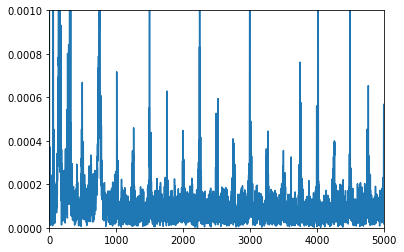

In [113]:
paths = ['/Volumes/Spindle/S2_MR1_U2/TEST_165(가속도 x 중간에 멈춤)', '/Volumes/Spindle/S2_MR1_U2/TEST_167(하중부가시험 영향으로 데이터가 많이 튐)', '/Volumes/Spindle/S2_MR1_U2/TEST_168',
        '/Volumes/Spindle/S2_MR1_U2/TEST_169', '/Volumes/Spindle/S2_MR1_U2/TEST_170', '/Volumes/Spindle/S2_MR1_U2/TEST_171',
        '/Volumes/Spindle/S2_MR1_U2/TEST_172', '/Volumes/Spindle/S2_MR1_U2/TEST_173', '/Volumes/Spindle/S2_MR1_U2/TEST_174',
        '/Volumes/Spindle/S2_MR1_U2/TEST_175', '/Volumes/Spindle/S2_MR1_U2/TEST_167(하중부가시험 영향으로 데이터가 많이 튐)']
dfs = merge_and_transform(paths, 1)

In [114]:
# dataframe as pickle file
save_paths = []
for i in range(len(dfs)):
    save_paths.append(paths[i].split('/')[4].split('(')[0]) # 괄호 제외, TEST_XXX
    with open('/Volumes/Spindle/S2_MR1_U2/PickleData/transformed_' + save_paths[i] + '.pickle', 'wb') as w:
        pickle.dump(dfs[i], w)

## Load transformed dataframe files and merge them

In [7]:
# load transformed dataframe files
dir_path = '/Volumes/Spindle/S2_MR1_U2/PickleData/'
data_paths = []

for dirname, _, filenames in os.walk(dir_path):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        if path.endswith('.pickle') and 'transformed' in filename and '.pickle' in filename:
            data_paths.append(path)

for i in range(5):
    print(data_paths[i])
print('transformed dataframe file 총 개수: ', len(data_paths))

/Volumes/Spindle/S2_MR1_U2/PickleData/transformed_TEST_160.pickle
/Volumes/Spindle/S2_MR1_U2/PickleData/transformed_TEST_163.pickle
/Volumes/Spindle/S2_MR1_U2/PickleData/transformed_TEST_165.pickle
/Volumes/Spindle/S2_MR1_U2/PickleData/transformed_TEST_166.pickle
/Volumes/Spindle/S2_MR1_U2/PickleData/transformed_TEST_167.pickle
transformed dataframe file 총 개수:  13


In [12]:
# merge them
df_list = []

for path in data_paths:
    with open(path, 'rb') as r:
        data = pickle.load(r)
    df_list.append(data)

df = pd.concat(df_list)
df.head()

,Filtered_freq_list,popCount_freq,popCount_x,popCount_y,popDegree_mean_x,popDegree_mean_y,popDegree_total_mean
0,"[296.0592118423685, 302.06041208241646, 305.06...",37,34,23,0.002791,0.002851,0.002815
1,"[296.0592118423685, 301.06021204240847, 302.06...",33,32,22,0.002903,0.002927,0.002913
2,"[296.0592118423685, 302.06041208241646, 304.06...",35,31,25,0.002958,0.002705,0.002845
3,"[296.0592118423685, 297.0594118823765, 302.060...",35,33,21,0.002736,0.002982,0.002832
4,"[274.05481096219245, 296.0592118423685, 301.06...",34,33,20,0.002734,0.003093,0.002869


In [15]:
df = df.astype({'popCount_freq' : 'float64'})
df = df.astype({'popCount_x' : 'float64'})
df = df.astype({'popCount_y' : 'float64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36889 entries, 0 to 29
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Filtered_freq_list    36889 non-null  object 
 1   popCount_freq         36889 non-null  float64
 2   popCount_x            36889 non-null  float64
 3   popCount_y            36889 non-null  float64
 4   popDegree_mean_x      36889 non-null  float64
 5   popDegree_mean_y      36889 non-null  float64
 6   popDegree_total_mean  36889 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.3+ MB


In [17]:
# save to another path
with open('/Volumes/Spindle/S2_MR1_U2/df_for_clustering/transformed_and_merged.pickle', 'wb') as w:
    pickle.dump(df, w)

In [5]:
# load
with open('/Volumes/Spindle/S2_MR1_U2/df_for_clustering/transformed_and_merged.pickle', 'rb') as r:
    df = pickle.load(r)

## Plot

Text(0.5, 0.92, 'Visualization')

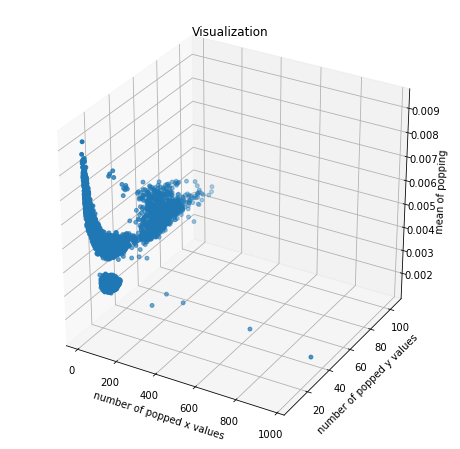

In [6]:
#3d scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['popCount_x'], df['popCount_y'], df['popDegree_total_mean'], marker='o', s=15)
ax.set_xlabel('number of popped x values')
ax.set_ylabel('number of popped y values')
ax.set_zlabel('mean of popping')
plt.title('Visualization')

# K-means Clustering (k = 4)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36889 entries, 0 to 29
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Filtered_freq_list    36889 non-null  object 
 1   popCount_freq         36889 non-null  float64
 2   popCount_x            36889 non-null  float64
 3   popCount_y            36889 non-null  float64
 4   popDegree_mean_x      36889 non-null  float64
 5   popDegree_mean_y      36889 non-null  float64
 6   popDegree_total_mean  36889 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.3+ MB


In [11]:
# set null to 0
df.fillna(0, inplace=True)
# df.isnull()

# normalization
normalizedf = df.drop(['Filtered_freq_list'], axis=1)
normalizedf = (normalizedf - normalizedf.mean()) / normalizedf.std()
df = pd.concat([df['Filtered_freq_list'], normalizedf], axis=1)
df.head()

,Filtered_freq_list,popCount_freq,popCount_x,popCount_y,popDegree_mean_x,popDegree_mean_y,popDegree_total_mean
0,"[296.0592118423685, 302.06041208241646, 305.06...",0.195756,0.147280,0.029982,-0.968840,-0.848909,-0.937271
1,"[296.0592118423685, 301.06021204240847, 302.06...",-0.169193,-0.071058,-0.092067,-0.837391,-0.789813,-0.837438
2,"[296.0592118423685, 302.06041208241646, 304.06...",0.013282,-0.180227,0.274079,-0.772354,-0.963108,-0.906939
3,"[296.0592118423685, 297.0594118823765, 302.060...",0.013282,0.038111,-0.214115,-1.034103,-0.746803,-0.920657
4,"[274.05481096219245, 296.0592118423685, 301.06...",-0.077956,0.038111,-0.336163,-1.036581,-0.660139,-0.881863


In [8]:
from sklearn.cluster import KMeans

dataset = pd.DataFrame({"popCount_x" : df['popCount_x'],
                        "popCount_y" : df['popCount_y'],
                        "popDegree_mean_x" : df['popDegree_mean_x'],
                        "popDegree_mean_y" : df['popDegree_mean_y']})
kmeans = KMeans(n_clusters=4)
kmeans.fit(dataset)
kmeans_label = kmeans.labels_

print(kmeans.score(dataset))

print("k-means labels")
print(kmeans_label)
print()
print()

print("k-means cluster centers")
print(kmeans.cluster_centers_)
predictions = kmeans.fit_predict(dataset)

resDF = df.copy()
resDF["prediction"] = kmeans.labels_
resDF.head()

-36430.262408678595
k-means labels
[0 0 0 ... 1 1 1]


k-means cluster centers
[[-0.21298475 -0.12642729 -0.98024252 -0.88673746]
 [ 0.24919793  0.05842481  0.69855067  0.5184487 ]
 [ 2.90639117  4.88998911  0.49521053  0.32237298]
 [-1.13165603 -1.32351267  1.72552067  2.2032614 ]]


,Filtered_freq_list,popCount_freq,popCount_x,popCount_y,popDegree_mean_x,popDegree_mean_y,popDegree_total_mean,prediction
0,"[296.0592118423685, 302.06041208241646, 305.06...",0.195756,0.147280,0.029982,-0.968840,-0.848909,-0.937271,0
1,"[296.0592118423685, 301.06021204240847, 302.06...",-0.169193,-0.071058,-0.092067,-0.837391,-0.789813,-0.837438,0
2,"[296.0592118423685, 302.06041208241646, 304.06...",0.013282,-0.180227,0.274079,-0.772354,-0.963108,-0.906939,0
3,"[296.0592118423685, 297.0594118823765, 302.060...",0.013282,0.038111,-0.214115,-1.034103,-0.746803,-0.920657,0
4,"[274.05481096219245, 296.0592118423685, 301.06...",-0.077956,0.038111,-0.336163,-1.036581,-0.660139,-0.881863,0


## Clustering result plot

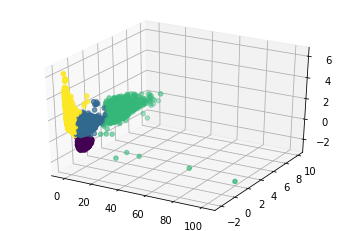

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(dataset['popCount_x'], dataset['popCount_y'], dataset['popDegree_mean_x'], c=kmeans_label)

# Analysis of Clustering

In [12]:
import random

## 1) Visualize the Frequency Distribution of each Clustered Data

### (1) Extract the data by each cluster and rand number

In [13]:
# cluster별 data 추출
cluster_0 = resDF[resDF.prediction == 0]
cluster_1 = resDF[resDF.prediction == 1]
cluster_2 = resDF[resDF.prediction == 2]

print(len(dataset))
print(len(cluster_0) + len(cluster_1) + len(cluster_2))
print(len(cluster_0), len(cluster_1), len(cluster_2))

36889
33882
17053 15766 1063


In [14]:
random.seed(2021)
randInd_0 = random.randrange(0, len(cluster_0))
randInd_1 = random.randrange(0, len(cluster_1))
randInd_2 = random.randrange(0, len(cluster_2))

print(randInd_0)
print(randInd_1)
print(randInd_2)

13245
14062
566


### (2) Cluster의 random point 별 Frequency 분포 확인

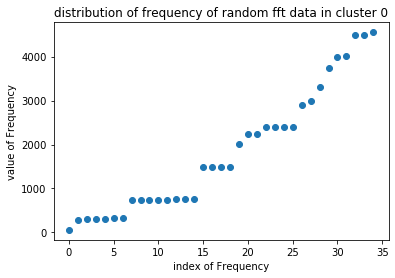

In [15]:
plt.plot(cluster_0.iloc[randInd_0]['Filtered_freq_list'], 'o')
plt.xlabel('index of Frequency')
plt.ylabel('value of Frequency')
plt.title('distribution of frequency of random fft data in cluster 0')
plt.show()

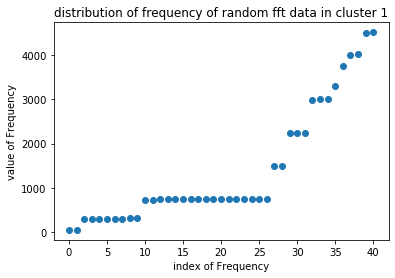

In [16]:
plt.plot(cluster_1.iloc[randInd_1]['Filtered_freq_list'], 'o')
plt.xlabel('index of Frequency')
plt.ylabel('value of Frequency')
plt.title('distribution of frequency of random fft data in cluster 1')
plt.show()

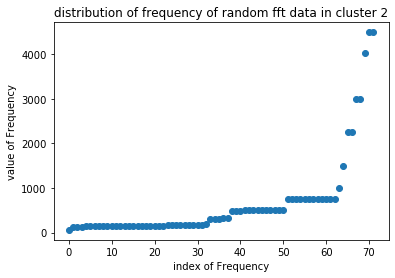

In [17]:
plt.plot(cluster_2.iloc[randInd_2]['Filtered_freq_list'], 'o')
plt.xlabel('index of Frequency')
plt.ylabel('value of Frequency')
plt.title('distribution of frequency of random fft data in cluster 2')
plt.show()

### (3) 다시 time domain에 cluster 색 별로 plot

In [18]:
len(resDF)

36889

36889
36889


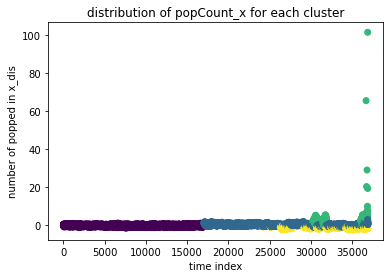

In [19]:
x = np.linspace(0,len(resDF), len(resDF))
print(len(x))
print(len(resDF['popCount_x']))
plt.scatter(x, resDF['popCount_x'], c=kmeans_label) #resDF['prediction'])
plt.xlabel('time index')
plt.ylabel('number of popped in x_dis')
plt.title('distribution of popCount_x for each cluster')
plt.show()

In [20]:
print(resDF.loc[resDF['prediction']])

                                   Filtered_freq_list  popCount_freq  \
0   [296.0592118423685, 302.06041208241646, 305.06...       0.195756   
0   [294.05881176235243, 295.0590118023605, 296.05...       1.290601   
0   [58.01160232046409, 301.06021204240847, 302.06...       1.108127   
0   [294.05881176235243, 301.06021204240847, 306.0...      -0.625378   
0   [58.01160232046409, 59.01180236047209, 60.0120...       3.936477   
..                                                ...            ...   
1   [58.01160232046409, 59.01180236047209, 60.0120...      -0.716615   
1   [59.01180236047209, 304.06081216243246, 306.06...      -0.899089   
1   [306.06121224244845, 307.0614122824565, 308.06...      -0.169193   
1   [305.06101220244045, 306.06121224244845, 308.0...      -0.442904   
1   [58.01160232046409, 59.01180236047209, 60.0120...       0.013282   

    popCount_x  popCount_y  popDegree_mean_x  popDegree_mean_y  \
0     0.147280    0.029982         -0.968840         -0.848909   
0  

## 2) Result of Clustering with k = 4

In [21]:
resDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36889 entries, 0 to 29
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Filtered_freq_list    36889 non-null  object 
 1   popCount_freq         36889 non-null  float64
 2   popCount_x            36889 non-null  float64
 3   popCount_y            36889 non-null  float64
 4   popDegree_mean_x      36889 non-null  float64
 5   popDegree_mean_y      36889 non-null  float64
 6   popDegree_total_mean  36889 non-null  float64
 7   prediction            36889 non-null  int32  
dtypes: float64(6), int32(1), object(1)
memory usage: 3.4+ MB


In [22]:
resDF.head()

,Filtered_freq_list,popCount_freq,popCount_x,popCount_y,popDegree_mean_x,popDegree_mean_y,popDegree_total_mean,prediction
0,"[296.0592118423685, 302.06041208241646, 305.06...",0.195756,0.147280,0.029982,-0.968840,-0.848909,-0.937271,0
1,"[296.0592118423685, 301.06021204240847, 302.06...",-0.169193,-0.071058,-0.092067,-0.837391,-0.789813,-0.837438,0
2,"[296.0592118423685, 302.06041208241646, 304.06...",0.013282,-0.180227,0.274079,-0.772354,-0.963108,-0.906939,0
3,"[296.0592118423685, 297.0594118823765, 302.060...",0.013282,0.038111,-0.214115,-1.034103,-0.746803,-0.920657,0
4,"[274.05481096219245, 296.0592118423685, 301.06...",-0.077956,0.038111,-0.336163,-1.036581,-0.660139,-0.881863,0


### (1) Extract the data by each cluster and define rand numbers

In [23]:
# cluster 별 data 추출
cluster_0 = resDF[resDF.prediction == 0]
cluster_1 = resDF[resDF.prediction == 1]
cluster_2 = resDF[resDF.prediction == 2]
cluster_3 = resDF[resDF.prediction == 3]

print(len(cluster_0) + len(cluster_1) + len(cluster_2) + len(cluster_3))
print(len(cluster_0), len(cluster_1), len(cluster_2), len(cluster_3))

36889
17053 15766 1063 3007


In [24]:
random.seed(1996)
# random points of cluster 0
randInd_0 = random.randrange(0, len(cluster_0))
randInd_0_1 = random.randrange(0, len(cluster_0))
randInd_0_2 = random.randrange(0, len(cluster_0))
randInd_0_3 = random.randrange(0, len(cluster_0))

# random points of cluster 1
randInd_1 = random.randrange(0, len(cluster_1))
randInd_1_1 = random.randrange(0, len(cluster_1))
randInd_1_2 = random.randrange(0, len(cluster_1))
randInd_1_3 = random.randrange(0, len(cluster_1))

# random points of cluster 2
randInd_2 = random.randrange(0, len(cluster_2))
randInd_2_1 = random.randrange(0, len(cluster_2))
randInd_2_2 = random.randrange(0, len(cluster_2))
randInd_2_3 = random.randrange(0, len(cluster_2))
randInd_2_4 = random.randrange(0, len(cluster_2))
randInd_2_5 = random.randrange(0, len(cluster_2))
randInd_2_6 = random.randrange(0, len(cluster_2))
randInd_2_7 = random.randrange(0, len(cluster_2))


# random points of cluster 3
randInd_3 = random.randrange(0, len(cluster_3))
randInd_3_1 = random.randrange(0, len(cluster_3))
randInd_3_2 = random.randrange(0, len(cluster_3))
randInd_3_3 = random.randrange(0, len(cluster_3))
randInd_3_4 = random.randrange(0, len(cluster_3))
randInd_3_5 = random.randrange(0, len(cluster_3))
randInd_3_6 = random.randrange(0, len(cluster_3))
randInd_3_7 = random.randrange(0, len(cluster_3))

print(randInd_0, randInd_0_1, randInd_0_2, randInd_0_3)
print(randInd_1, randInd_1_1, randInd_1_2, randInd_1_3)
print(randInd_2, randInd_2_1, randInd_2_2, randInd_2_3, randInd_2_4, randInd_2_5, randInd_2_6, randInd_2_7)
print(randInd_3, randInd_3_1, randInd_3_2, randInd_3_3, randInd_3_4, randInd_3_5, randInd_3_6, randInd_3_7)

14902 13724 9912 7274
8757 15128 6198 793
538 581 753 771 121 30 697 36
1664 38 691 1355 1059 1300 1026 2049


### (2) Cluster의 random point 별 Frequency 분포 확인

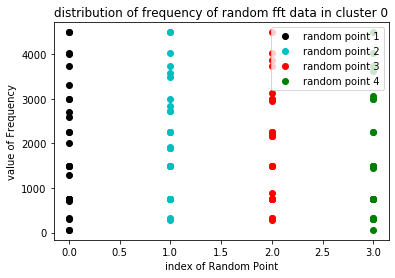

In [25]:
x_1 = [0 for i in range(len(cluster_0.iloc[randInd_0]['Filtered_freq_list']))]
x_2 = [1 for i in range(len(cluster_0.iloc[randInd_0_1]['Filtered_freq_list']))]
x_3 = [2 for i in range(len(cluster_0.iloc[randInd_0_2]['Filtered_freq_list']))]
x_4 = [3 for i in range(len(cluster_0.iloc[randInd_0_3]['Filtered_freq_list']))]

plt.plot(x_1, cluster_0.iloc[randInd_0]['Filtered_freq_list'], 'ko', label='random point 1')
plt.plot(x_2, cluster_0.iloc[randInd_0_1]['Filtered_freq_list'], 'co', label='random point 2')
plt.plot(x_3, cluster_0.iloc[randInd_0_2]['Filtered_freq_list'], 'ro', label='random point 3')
plt.plot(x_4, cluster_0.iloc[randInd_0_3]['Filtered_freq_list'], 'go', label='random point 4')
plt.xlabel('index of Random Point')
plt.ylabel('value of Frequency')
plt.title('distribution of frequency of random fft data in cluster 0')
plt.legend()
plt.show()

k : 4     cost : 2564638.231278411
k : 5     cost : 1711841.1846668865
k : 6     cost : 884179.4864273918
k : 7     cost : 492545.21505087835
k : 8     cost : 255176.14358372107
k : 9     cost : 190888.18097019423
k : 10     cost : 128234.95551947628


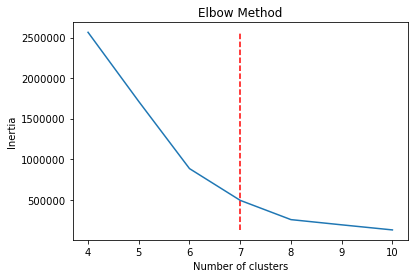

In [26]:
# Clustering of the Frequency Distribution
inertiaArr = []
kVals = range(4, 11)

for k in kVals:
    kmeans = KMeans(n_clusters=k, random_state=2021)
    kmeans.fit(cluster_0.iloc[randInd_0]['Filtered_freq_list'].reshape(-1, 1))
    inertia = kmeans.inertia_

    print('k :', k, '   ', 'cost :', inertia)
    inertiaArr.append(inertia)

inertiaArr = np.array(inertiaArr)
plt.plot(kVals, inertiaArr)
plt.vlines(7, ymin=inertiaArr.min() * 0.9999, ymax=inertiaArr.max() * 1.0003, linestyles='--', colors='r') # elbow point
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

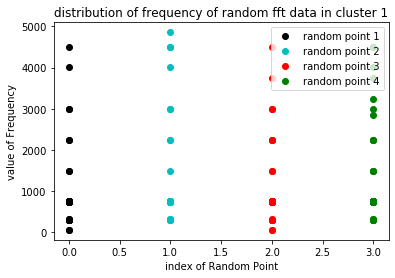

In [27]:
x_1 = [0 for i in range(len(cluster_1.iloc[randInd_1]['Filtered_freq_list']))]
x_2 = [1 for i in range(len(cluster_1.iloc[randInd_1_1]['Filtered_freq_list']))]
x_3 = [2 for i in range(len(cluster_1.iloc[randInd_1_2]['Filtered_freq_list']))]
x_4 = [3 for i in range(len(cluster_1.iloc[randInd_1_3]['Filtered_freq_list']))]

plt.plot(x_1, cluster_1.iloc[randInd_1]['Filtered_freq_list'], 'ko', label='random point 1')
plt.plot(x_2, cluster_1.iloc[randInd_1_1]['Filtered_freq_list'], 'co', label='random point 2')
plt.plot(x_3, cluster_1.iloc[randInd_1_2]['Filtered_freq_list'], 'ro', label='random point 3')
plt.plot(x_4, cluster_1.iloc[randInd_1_3]['Filtered_freq_list'], 'go', label='random point 4')
plt.xlabel('index of Random Point')
plt.ylabel('value of Frequency')
plt.title('distribution of frequency of random fft data in cluster 1')
plt.legend()
plt.show()

k : 5     cost : 731289.7366430685
k : 6     cost : 357638.7912109336
k : 7     cost : 90821.9918305192
k : 8     cost : 257.6030309082437
k : 9     cost : 116.71334733706708
k : 10     cost : 34.18033743442642
k : 11     cost : 18.67413557393017


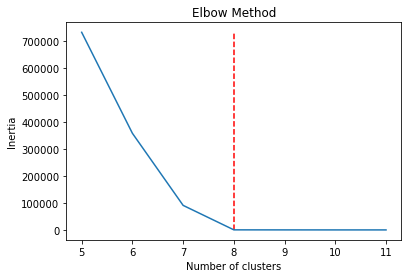

In [28]:
# Clustering of the Frequency Distribution
inertiaArr = []
kVals = range(5, 12)

for k in kVals:
    kmeans = KMeans(n_clusters=k, random_state=2021)
    kmeans.fit(cluster_1.iloc[randInd_1_1]['Filtered_freq_list'].reshape(-1, 1))
    inertia = kmeans.inertia_

    print('k :', k, '   ', 'cost :', inertia)
    inertiaArr.append(inertia)

inertiaArr = np.array(inertiaArr)
plt.plot(kVals, inertiaArr)
plt.vlines(8, ymin=inertiaArr.min() * 0.9999, ymax=inertiaArr.max() * 1.0003, linestyles='--', colors='r') # elbow point
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

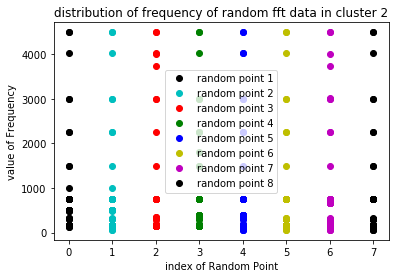

In [29]:
x_1 = [0 for i in range(len(cluster_2.iloc[randInd_2]['Filtered_freq_list']))]
x_2 = [1 for i in range(len(cluster_2.iloc[randInd_2_1]['Filtered_freq_list']))]
x_3 = [2 for i in range(len(cluster_2.iloc[randInd_2_2]['Filtered_freq_list']))]
x_4 = [3 for i in range(len(cluster_2.iloc[randInd_2_3]['Filtered_freq_list']))]
x_5 = [4 for i in range(len(cluster_2.iloc[randInd_2_4]['Filtered_freq_list']))]
x_6 = [5 for i in range(len(cluster_2.iloc[randInd_2_5]['Filtered_freq_list']))]
x_7 = [6 for i in range(len(cluster_2.iloc[randInd_2_6]['Filtered_freq_list']))]
x_8 = [7 for i in range(len(cluster_2.iloc[randInd_2_7]['Filtered_freq_list']))]

plt.plot(x_1, cluster_2.iloc[randInd_2]['Filtered_freq_list'], 'ko', label='random point 1')
plt.plot(x_2, cluster_2.iloc[randInd_2_1]['Filtered_freq_list'], 'co', label='random point 2')
plt.plot(x_3, cluster_2.iloc[randInd_2_2]['Filtered_freq_list'], 'ro', label='random point 3')
plt.plot(x_4, cluster_2.iloc[randInd_2_3]['Filtered_freq_list'], 'go', label='random point 4')
plt.plot(x_5, cluster_2.iloc[randInd_2_4]['Filtered_freq_list'], 'bo', label='random point 5')
plt.plot(x_6, cluster_2.iloc[randInd_2_5]['Filtered_freq_list'], 'yo', label='random point 6')
plt.plot(x_7, cluster_2.iloc[randInd_2_6]['Filtered_freq_list'], 'mo', label='random point 7')
plt.plot(x_8, cluster_2.iloc[randInd_2_7]['Filtered_freq_list'], 'ko', label='random point 8')
plt.xlabel('index of Random Point')
plt.ylabel('value of Frequency')
plt.title('distribution of frequency of random fft data in cluster 2')
plt.legend()
plt.show()

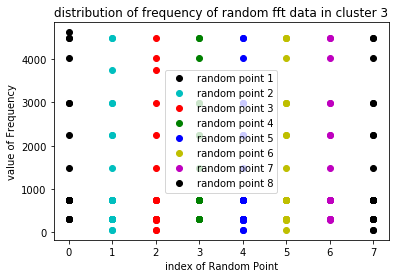

In [30]:
x_1 = [0 for i in range(len(cluster_3.iloc[randInd_3]['Filtered_freq_list']))]
x_2 = [1 for i in range(len(cluster_3.iloc[randInd_3_1]['Filtered_freq_list']))]
x_3 = [2 for i in range(len(cluster_3.iloc[randInd_3_2]['Filtered_freq_list']))]
x_4 = [3 for i in range(len(cluster_3.iloc[randInd_3_3]['Filtered_freq_list']))]
x_5 = [4 for i in range(len(cluster_3.iloc[randInd_3_4]['Filtered_freq_list']))]
x_6 = [5 for i in range(len(cluster_3.iloc[randInd_3_5]['Filtered_freq_list']))]
x_7 = [6 for i in range(len(cluster_3.iloc[randInd_3_6]['Filtered_freq_list']))]
x_8 = [7 for i in range(len(cluster_3.iloc[randInd_3_7]['Filtered_freq_list']))]

plt.plot(x_1, cluster_3.iloc[randInd_3]['Filtered_freq_list'], 'ko', label='random point 1')
plt.plot(x_2, cluster_3.iloc[randInd_3_1]['Filtered_freq_list'], 'co', label='random point 2')
plt.plot(x_3, cluster_3.iloc[randInd_3_2]['Filtered_freq_list'], 'ro', label='random point 3')
plt.plot(x_4, cluster_3.iloc[randInd_3_3]['Filtered_freq_list'], 'go', label='random point 4')
plt.plot(x_5, cluster_3.iloc[randInd_3_4]['Filtered_freq_list'], 'bo', label='random point 5')
plt.plot(x_6, cluster_3.iloc[randInd_3_5]['Filtered_freq_list'], 'yo', label='random point 6')
plt.plot(x_7, cluster_3.iloc[randInd_3_6]['Filtered_freq_list'], 'mo', label='random point 7')
plt.plot(x_8, cluster_3.iloc[randInd_3_7]['Filtered_freq_list'], 'ko', label='random point 8')
plt.xlabel('index of Random Point')
plt.ylabel('value of Frequency')
plt.title('distribution of frequency of random fft data in cluster 3')
plt.legend()
plt.show()

k : 3     cost : 2315396.232543835
k : 4     cost : 1217723.4346042988
k : 5     cost : 523483.0389429225
k : 6     cost : 149832.09351078758
k : 7     cost : 304.1216364897306
k : 8     cost : 101.7406922072544
k : 9     cost : 41.71668500533386


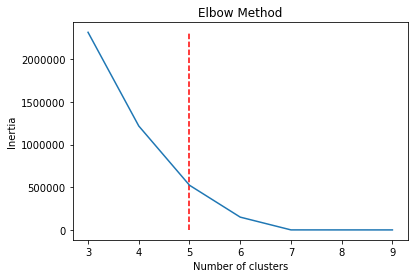

In [31]:
# Clustering of the Frequency Distribution
inertiaArr = []
kVals = range(3, 10)

for k in kVals:
    kmeans = KMeans(n_clusters=k, random_state=2021)
    kmeans.fit(cluster_3.iloc[randInd_3_3]['Filtered_freq_list'].reshape(-1, 1))
    inertia = kmeans.inertia_

    print('k :', k, '   ', 'cost :', inertia)
    inertiaArr.append(inertia)

inertiaArr = np.array(inertiaArr)
plt.plot(kVals, inertiaArr)
plt.vlines(5, ymin=inertiaArr.min() * 0.9999, ymax=inertiaArr.max() * 1.0003, linestyles='--', colors='r') # elbow point
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()